# 05. Building Intelligent Agents

## 0. 安装依赖

In [ ]:
%uv pip install langchain-core~=0.3 langchain-openai~=0.3 

In [ ]:
%uv pip install python-dotenv~=1.1

In [ ]:
%uv pip install langchain~=0.3

In [ ]:
%uv pip install langgraph~=0.6

In [ ]:
%uv pip install langchain-community~=0.3

In [ ]:
import os

import dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


class Config:
    def __init__(self):
        # By default, load_dotenv doesn't override existing environment variables and looks for a .env file in same directory as python script or searches for it incrementally higher up.
        dotenv_path = dotenv.find_dotenv(usecwd=True)
        if not dotenv_path:
            raise ValueError("No .env file found")
        dotenv.load_dotenv(dotenv_path=dotenv_path)

        api_key = os.getenv("OPENAI_API_KEY")
        if not api_key:
            raise ValueError("OPENAI_API_KEY is not set")

        base_url = os.getenv("OPENAI_API_BASE_URL")
        if not base_url:
            raise ValueError("OPENAI_API_BASE_URL is not set")

        model = os.getenv("OPENAI_MODEL")
        if not model:
            raise ValueError("OPENAI_MODEL is not set")

        embeddings_model = os.getenv("OPENAI_EMBEDDINGS_MODEL")
        hf_pretrained_embeddings_model = os.getenv("HF_PRETRAINED_EMBEDDINGS_MODEL")

        self.api_key = api_key
        self.base_url = base_url
        self.model = model
        self.embeddings_model = embeddings_model
        self.hf_pretrained_embeddings_model = hf_pretrained_embeddings_model if hf_pretrained_embeddings_model else 'Qwen/Qwen3-Embedding-8B'

    def new_openai_like(self, **kwargs) -> ChatOpenAI:
        # 参考：https://bailian.console.aliyun.com/?tab=api#/api/?type=model&url=2587654
        # 参考：https://help.aliyun.com/zh/model-studio/models
        # ChatOpenAI 文档参考：https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html#langchain_openai.chat_models.base.ChatOpenAI
        return ChatOpenAI(
            api_key=self.api_key, base_url=self.base_url, model=self.model, **kwargs
        )

    def new_openai_like_embeddings(self, **kwargs) -> OpenAIEmbeddings:
        if not self.embeddings_model:
            raise ValueError("OPENAI_EMBEDDINGS_MODEL is not set")

        # 参考：https://python.langchain.com/api_reference/openai/embeddings/langchain_openai.embeddings.base.OpenAIEmbeddings.html#langchain_openai.embeddings.base.OpenAIEmbeddings
        return OpenAIEmbeddings(
            api_key=self.api_key,
            base_url=self.base_url,
            model=self.embeddings_model,
            # https://python.langchain.com/api_reference/openai/embeddings/langchain_openai.embeddings.base.OpenAIEmbeddings.html#langchain_openai.embeddings.base.OpenAIEmbeddings.tiktoken_enabled
            # 对于非 OpenAI 的官方实现，将这个参数置为 False。
            # 回退到用 huggingface transformers 库 AutoTokenizer 来处理 token。
            tiktoken_enabled=False,
            # https://python.langchain.com/api_reference/openai/embeddings/langchain_openai.embeddings.base.OpenAIEmbeddings.html#langchain_openai.embeddings.base.OpenAIEmbeddings.model
            # 元宝说 Jina 的 embedding 模型 https://huggingface.co/jinaai/jina-embeddings-v4 最接近
            # text-embedding-ada-002
            # 个人喜好，选了 Qwen/Qwen3-Embedding-8B
            # tiktoken_model_name='Qwen/Qwen3-Embedding-8B',
            tiktoken_model_name=self.hf_pretrained_embeddings_model,
            **kwargs
        )

## What is a tool?

In [ ]:
from langchain_core.prompts import PromptTemplate


question = "how old is the US president?"

raw_prompt_template = (
  "You have access to search engine that provides you an "
  "information about fresh events and news given the query. "
  "Given the question, decide whether you need an additional "
  "information from the search engine (reply with 'SEARCH: "
   "<generated query>' or you know enough to answer the user "
   "then reply with 'RESPONSE <final response>').\n"
   "Do not make any assumptions on recent events or things that can change."
   "Now, act to answer a user question:\n{QUESTION}"
)

prompt_template = PromptTemplate.from_template(raw_prompt_template)

llm = Config().new_openai_like()

(prompt_template | llm).invoke(question).content

In [ ]:
question1 = "What is the capital of Germany?"

(prompt_template | llm).invoke(question1).content

In [ ]:
query = "age of current US president"
search_result = (
    "Donald Trump › Age 78 years June 14, 1946\n"
    "Donald Trump 45th and 47th U.S. President Donald John Trump is an American "
    "politician, media personality, and businessman who has served as the 47th "
    "president of the United States since January 20, 2025. A member of the "
    "Republican Party, he previously served as the 45th president from 2017 to 2021. Wikipedia"
)

raw_prompt_template = (
    "You have access to search engine that provides you an "
    "information about fresh events and news given the query. "
    "Given the question, decide whether you need an additional "
    "information from the search engine (reply with 'SEARCH: "
    "<generated query>' or you know enough to answer the user "
    "then reply with 'RESPONSE <final response>').\n"
    "Today is {date}."
    "Now, act to answer a user question and "
    "take into account your previous actions:\n"
    "HUMAN: {question}\n"
    "AI: SEARCH: {query}\n"
    "RESPONSE FROM SEARCH: {search_result}\n"
)
prompt_template = PromptTemplate.from_template(raw_prompt_template)

result = (prompt_template | llm).invoke(
    {
        "question": question,
        "query": query,
        "search_result": search_result,
        "date": "Feb 2025",
    }
)

print(result.content)

In [ ]:
query = "current US president"
search_result = "Donald Trump 45th and 47th U.S."

raw_prompt_template = (
    "You have access to search engine that provides you an "
    "information about fresh events and news given the query. "
    "Given the question, decide whether you need an additional "
    "information from the search engine (reply with 'SEARCH: "
    "<generated query>' or you know enough to answer the user "
    "then reply with 'RESPONSE <final response>').\n"
    "Today is {date}."
    "Now, act to answer a user question and "
    "take into account your previous actions:\n"
    "HUMAN: {question}\n"
    "AI: SEARCH: {query}\n"
    "RESPONSE FROM SEARCH: {search_result}\n"
)
prompt_template = PromptTemplate.from_template(raw_prompt_template)

result = (prompt_template | llm).invoke(
    {
        "question": question,
        "query": query,
        "search_result": search_result,
        "date": "Feb 2025",
    }
)
print(result.content)

### Tools in LangChain

In [ ]:
search_tool = {
    "type": "function",
    "function": {
        "name": "google_search",
        "description": "Returns about common facts, fresh events and news from Google Search engine based on a query.",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "title": "search_query",
                    "description": "Search query to be sent to the search engine",
                }
            },
            "required": ["query"],
        },
    },
}

step1 = llm.invoke(question, tools=[search_tool])

step1.tool_calls

In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage

tool_result = ToolMessage(
    content="Donald Trump › Age 78 years June 14, 1946\n",
    tool_call_id=step1.tool_calls[0]["id"],
)
step2 = llm.invoke(
    [HumanMessage(content=question), step1, tool_result], tools=[search_tool]
)
assert len(step2.tool_calls) == 0

print(step2.content)

In [ ]:
llm_with_tools = llm.bind(tools=[search_tool])

llm_with_tools.invoke(question)

### ReACT

In [ ]:
import math


def mocked_google_search(query: str) -> str:
    print(f"CALLED GOOGLE_SEARCH with query={query}")
    return "Donald Trump is a president of USA and he's 78 years old"


def mocked_calculator(expression: str) -> float:
    print(f"CALLED CALCULATOR with expression={expression}")
    if "sqrt" in expression:
        return math.sqrt(78 * 132)
    return 78 * 132

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

calculator_tool = {
    "type": "function",
    "function": {
        "name": "calculator",
        "description": "Computes mathematical expressions",
        "parameters": {
            "type": "object",
            "properties": {
                "expression": {
                    "type": "string",
                    "title": "expression",
                    "description": "A mathematical expression to be evaluated by a calculator",
                }
            },
            "required": ["expression"],
        },
    },
}

search_tool = {
    "type": "function",
    "function": {
        "name": "google_search",
        "description": "Returns about common facts, fresh events and news from Google Search engine based on a query.",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "title": "search_query",
                    "description": "Search query to be sent to the search engine",
                }
            },
            "required": ["query"],
        },
    },
}

system_prompt = (
    "Always use a calculator for mathematical computations, and use Google Search "
    "for information about common facts, fresh events and news. Do not assume anything, keep in "
    "mind that things are changing and always "
    "check yourself with external sources if possible."
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


In [ ]:
llm_with_tools = prompt | llm.bind_tools([search_tool, calculator_tool])

In [ ]:
from langchain_core.messages import ToolMessage
from langgraph.graph import MessagesState, START, END


def invoke_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


def call_tools(state: MessagesState):
    last_message = state["messages"][-1]
    tool_calls = last_message.tool_calls

    new_messages = []

    for tool_call in tool_calls:
        if tool_call["name"] == "google_search":
            tool_result = mocked_google_search(**tool_call["args"])
            new_messages.append(
                ToolMessage(content=tool_result, tool_call_id=tool_call["id"])
            )
        elif tool_call["name"] == "calculator":
            tool_result = mocked_calculator(**tool_call["args"])
            new_messages.append(
                ToolMessage(content=tool_result, tool_call_id=tool_call["id"])
            )
        else:
            raise ValueError(f"Tool {tool_call['name']} is not defined!")
    return {"messages": new_messages}


def should_run_tools(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "call_tools"
    return END

In [ ]:
from langgraph.graph import MessagesState, StateGraph


builder = StateGraph(MessagesState)
builder.add_node("invoke_llm", invoke_llm)
builder.add_node("call_tools", call_tools)

builder.add_edge(START, "invoke_llm")
builder.add_conditional_edges("invoke_llm", should_run_tools)
builder.add_edge("call_tools", "invoke_llm")
graph = builder.compile()

question = "What is a square root of the current US president’s age multiplied by 132?"

result = graph.invoke({"messages": [HumanMessage(content=question)]})
print(result["messages"][-1].content)

In [ ]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(model=llm, tools=[search_tool, calculator_tool], prompt=system_prompt)

## Defining tools

### Built-in LangChain tools

In [ ]:
%uv pip install ddgs~=9.6

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun(api_wrapper_kwargs={"backend": "api"})
print(f"Tool's name = {search.name}")
print(f"Tool's name = {search.description}")
print(f"Tool's arg schema = {search.args_schema}")

In [ ]:
from langchain_community.tools.ddg_search.tool import DDGInput


DDGInput.model_fields

In [ ]:
query = "What is the weather in Munich like tomorrow?"
search_input = DDGInput(query=query)
search.invoke(search_input.model_dump())

In [ ]:
# llm.invoke(query, tools=[search]) 会要求包 search 不是合法的 json 对象。
llm.bind_tools([search]).invoke(query)

In [ ]:
result = llm.bind_tools([search]).invoke(
    [
        (
            "system",
            "Always use a duckduckgo_search tool for queries that require a fresh information",
        ),
        ("user", "How much is 2+2?"),
    ]
)
assert not result.tool_calls

In [ ]:
from langgraph.prebuilt import create_react_agent


agent = create_react_agent(
  model=llm,
  tools=[search],
  prompt="Always use a duckduckgo_search tool for queries that require a fresh information"
)

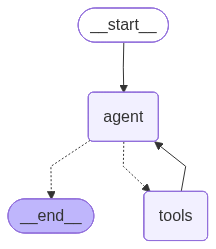

In [113]:
from IPython.display import Image, display


display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
for event in agent.stream({"messages": [("user", query)]}):
  messages = event.get("agent", event.get("tools", {})).get("messages", [])
  for m in messages:
     m.pretty_print()

In [ ]:
from langchain_community.agent_toolkits.openapi.toolkit import RequestsToolkit
from langchain_community.utilities.requests import TextRequestsWrapper

toolkit = RequestsToolkit(
    requests_wrapper=TextRequestsWrapper(headers={}),
    allow_dangerous_requests=True,
)

for tool in toolkit.get_tools():
    print(tool.name)

In [ ]:
api_spec = """
openapi: 3.0.0
info:
  title: Frankfurter Currency Exchange API
  version: v1
  description: API for retrieving currency exchange rates. Pay attention to the base currency and change it if needed.

servers:
  - url: https://api.frankfurter.dev/v1

paths:
  /v1/{date}:
    get:
      summary: Get exchange rates for a specific date.
      parameters:
        - in: path
          name: date
          schema:
            type: string
            pattern: '^\d{4}-\d{2}-\d{2}$' # YYYY-MM-DD format
          required: true
          description: The date for which to retrieve exchange rates.  Use YYYY-MM-DD format.  Example: 2009-01-04
        - in: query
          name: symbols
          schema:
            type: string
          description: Comma-separated list of currency symbols to retrieve rates for. Example: GBP,USD,EUR

  /v1/latest:
    get:
      summary: Get the latest exchange rates.
      parameters:
        - in: query
          name: symbols
          schema:
            type: string
          description: Comma-separated list of currency symbols to retrieve rates for. Example: CHF,GBP
        - in: query
          name: base
          schema:
            type: string
          description: The base currency for the exchange rates. If not provided, EUR is used as a base currency. Example: USD
"""

In [ ]:
system_message = (
    "You're given the API spec:\n{api_spec}\n"
    "Use the API to answer users' queries if possible. "
)

agent = create_react_agent(
    llm, toolkit.get_tools(), prompt=system_message.format(api_spec=api_spec)
)

query = "What is the swiss franc to US dollar exchange rate?"

events = agent.stream(
    {"messages": [("user", query)]},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

### Custom tools

#### Wrapping a Python function as a tool

In [ ]:
%uv pip install numexpr~=2.13

In [ ]:
import numexpr as ne
import math

math_constants = {"pi": math.pi, "i": 1j, "e": math.exp},
ne.evaluate(("2+2"), local_dict=math_constants)

In [ ]:
from langchain_core.tools import tool


@tool
def calculator(expression: str) -> str:
    """Calculates a single mathematical expression, incl. complex numbers.

    Always add * to operations, examples:
      73i -> 73*i
      7pi**2 -> 7*pi**2
    """
    math_constants = {"pi": math.pi, "i": 1j, "e": math.exp}
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)

In [ ]:
from langchain_core.tools import BaseTool


assert isinstance(calculator, BaseTool)

print(f"Tool name: {calculator.name}")
print(f"Tool description: {calculator.description}")
print(f"Tool schema: {calculator.args_schema.model_json_schema()}")

In [ ]:
from langgraph.prebuilt import create_react_agent


query = "How much is 2+3i squared?"

agent = create_react_agent(llm, [calculator])

for event in agent.stream({"messages": [("user", query)]}, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun


search = DuckDuckGoSearchRun()

question = "What is a square root of the current US president's age multiplied by 132?"

system_hint = "Think step-by-step. Always use search to get the fresh information about events or public facts that can change over time. Now is 2025 and remember president elections in the US recently happened."

agent = create_react_agent(llm, [calculator, search], prompt=system_hint)

for event in agent.stream({"messages": [("user", question)]}, stream_mode="values"):
    event["messages"][-1].pretty_print()

#### Creating a tool from a Runnable

In [ ]:
from langchain_core.runnables import RunnableLambda
from langchain_core.tools import convert_runnable_to_tool


def calculator(expression: str) -> str:
    math_constants = {"pi": math.pi, "i": 1j, "e": math.exp}
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)


calculator_with_retry = RunnableLambda(calculator).with_retry(
    wait_exponential_jitter=True,
    stop_after_attempt=3,
)

In [ ]:
calculator_tool = convert_runnable_to_tool(
    calculator_with_retry,
    name="calculator",
    description=(
        "Calculates a single mathematical expression, incl. complex numbers."
        "'\nAlways add * to operations, examples:\n73i -> 73*i\n"
        "7pi**2 -> 7*pi**2"
    ),
    arg_types={"expression": "str"},
)

In [ ]:
# 原书的错误调用方式：
#   llm.invoke("How much is (2+3i)**2", tools=[calculator_tool]).tool_calls[0]
# 具体错误提示片段为：
#  Unable to serialize unknown type: <class 'method'>

llm.bind_tools([calculator_tool]).invoke("How much is (2+3i)**2")

In [ ]:
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnableConfig


class CalculatorArgs(BaseModel):
    expression: str = Field(description="Mathematical expression to be evaluated")


def calculator(state: CalculatorArgs, config: RunnableConfig) -> str:
    expression = state["expression"]
    math_constants = config["configurable"].get("math_constants", {})
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)


calculator_with_retry = RunnableLambda(calculator).with_retry(
    wait_exponential_jitter=True,
    stop_after_attempt=3,
)

calculator_tool = convert_runnable_to_tool(
    calculator_with_retry,
    name="calculator",
    description=(
        "Calculates a single mathematical expression, incl. complex numbers."
        "'\nAlways add * to operations, examples:\n73i -> 73*i\n"
        "7pi**2 -> 7*pi**2"
    ),
    args_schema=CalculatorArgs,
    arg_types={"expression": "str"},
)

assert isinstance(calculator_tool, BaseTool)

print(f"Tool name: {calculator_tool.name}")
print(f"Tool description: {calculator_tool.description}")
print(f"Args schema: {calculator_tool.args_schema.model_json_schema()}")

In [ ]:
math_constants = {"pi": math.pi, "i": 1j, "e": math.exp}
config = {"configurable": {"math_constants": math_constants}}

# 错误调用方式：tool_call = llm.invoke("How much is (2+3i)**2", tools=[calculator_tool]).tool_calls[0]
tool_call = llm.bind_tools([calculator_tool]).invoke("How much is (2+3i)**2").tool_calls[0]
print(tool_call)

In [ ]:
calculator_tool.invoke(tool_call["args"], config=config)

#### Subclass StructuredTool or BaseTool

In [ ]:
from langchain_core.tools import StructuredTool


def calculator(expression: str) -> str:
    math_constants = {"pi": math.pi, "i": 1j, "e": math.exp}
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)


calculator_tool = StructuredTool.from_function(
    name="calculator",
    description=("Calculates a single mathematical expression, incl. complex numbers."),
    func=calculator,
    args_schema=CalculatorArgs,
)

llm.bind_tools([calculator_tool]).invoke("How much is (2+3i)**2").tool_calls[0]

### Error handling

In [ ]:
from langchain_core.tools import StructuredTool


def calculator(expression: str) -> str:
    """Calculates a single mathematical expression, incl. complex numbers."""
    return str(ne.evaluate(expression.strip(), local_dict={}))

calculator_tool = StructuredTool.from_function(
    func=calculator,
    handle_tool_error=True
)

agent = create_react_agent(
    llm, [calculator_tool])

for event in agent.stream({"messages": [("user", "How much is (2+3i)^2")]}, stream_mode="values", config=config):
    event["messages"][-1].pretty_print()

## Advanced tool-calling capabilities

## Incorporating tools into workflows

### Controlled generation

In [98]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: list[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [100]:
prompt = PromptTemplate.from_template(
    "Prepare a step-by-step plan to solve the given task. "
    " Return the answer in JSON format."
    " Each step should be a recorded in plan's steps field.\n"
    "TASK:\n{task}\n"
)

query = "How to write a bestseller on Amazon about generative AI?"

result = (prompt | llm.with_structured_output(Plan)).invoke(query)

In [101]:
assert isinstance(result, Plan)

print(f"Amount of steps: {len(result.steps)}")

for step in result.steps:
  print(step)
  break

Amount of steps: 15
Research the current market on Amazon to identify top-selling books about generative AI, including their titles, structures, pricing, and customer reviews.


#### Controlled generation provided by the vendor

In [ ]:
plan_schema = {
    "type": "ARRAY",
    "items": {
        "type": "OBJECT",
          "properties": {
              "step": {"type": "STRING"},
          },
      },
}

query = "How to write a bestseller on Amazon about generative AI?"

result = (prompt | llm.with_structured_output(schema=plan_schema, method="json_mode")).invoke(query)

# FIXME: result is a dict with a single key "steps"
assert(isinstance(result, list))
print(f"Amount of steps: {len(result)}")
print(result[0])

AssertionError: 

### ToolNode

In [114]:
import math
import numexpr as ne
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun


search = DuckDuckGoSearchRun()

@tool
def calculator(expression: str) -> str:
    """Calculates a single mathematical expression, incl. complex numbers.

    Always add * to operations, examples:
      73i -> 73*i
      7pi**2 -> 7*pi**2
    """
    math_constants = {"pi": math.pi, "i": 1j, "e": math.exp}
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)


llm_with_tools = Config().new_openai_like().bind_tools([search, calculator])

In [118]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph, START, END

def invoke_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("invoke_llm", invoke_llm)
builder.add_node("tools", ToolNode([search, calculator]))

builder.add_edge(START, "invoke_llm")
builder.add_conditional_edges("invoke_llm", tools_condition)
builder.add_edge("tools", "invoke_llm")
# builder.add_edge("tools", END)
builder.add_edge("invoke_llm", END)

graph = builder.compile()

In [119]:
from IPython.display import Image, display

# FIXME: 因未知原因画不出来。
display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [ ]:
# FIXME: 只输出一条消息不合理。
for e in graph.stream({"messages": ("human", "How much is 2+2")}):
  print(e)

{'invoke_llm': {'messages': [AIMessage(content='calculator{"expression": "2+2"}', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 282, 'total_tokens': 291, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-2025-09-11', 'system_fingerprint': None, 'id': 'chatcmpl-16a284df-7717-4aac-957e-9544f2b63a88', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--6948fa3d-e369-4056-9c3a-119d1912360f-0', usage_metadata={'input_tokens': 282, 'output_tokens': 9, 'total_tokens': 291, 'input_token_details': {}, 'output_token_details': {}})]}}


### Tool-calling paradigm

In [120]:
examples = [
  "I signed my contract 2 years ago",
  "I started the deal with your company in February last year",
  "Our contract started on March 24th two years ago"
]

In [121]:
from datetime import date, timedelta


@tool
def get_date(year: int, month: int = 1, day: int = 1) -> date:
    """Returns a date object given year, month and day.

      Default month and day are 1 (January) and 1.
      Examples in YYYY-MM-DD format:
        2023-07-27 -> date(2023, 7, 27)
        2022-12-15 -> date(2022, 12, 15)
        March 2022 -> date(2022, 3)
        2021 -> date(2021)
    """
    return date(year, month, day).isoformat()


@tool
def time_difference(days: int = 0, weeks: int = 0, months: int = 0, years: int = 0) -> date:
    """Returns a date given a difference in days, weeks, months and years relative to the current date.

    By default, dayss, weeks, months and years are 0.
    Examples:
      two weeks ago -> time_difference(weeks=2)
      last year -> time_difference(years=1)
    """
    dt = date.today() - timedelta(days=days, weeks=weeks)
    new_year = dt.year+(dt.month-months) // 12 - years
    new_month = (dt.month-months) % 12
    return dt.replace(year=new_year, month=new_month)

In [123]:
from langgraph.prebuilt import create_react_agent


llm = Config().new_openai_like()

agent = create_react_agent(
    llm,
    [get_date, time_difference],
    prompt="Extract the starting date of a contract. Current year is 2025.",
)


for example in examples:
    result = agent.invoke({"messages": [("user", example)]})
    print(example, result["messages"][-1].content)
    print()

I signed my contract 2 years ago Your contract was signed on September 27, 2023.

I started the deal with your company in February last year The contract started on **February 1, 2024**.

Our contract started on March 24th two years ago The contract started on March 24, 2023.



## What are agents?

### Plan-and-solve agent

In [ ]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: list[str] = Field(
        description="different steps to follow, should be in sorted order"
    )


system_prompt_template = (
    "For the given task, come up with a step by step plan.\n"
    "This plan should involve individual tasks, that if executed correctly will "
    "yield the correct answer in JSON format and recorded in field 'steps'.\n"
    "Do not add any superfluous steps.\n"
    "The result of the final step should be the final answer. Make sure that each "
    "step has all the information needed - do not skip steps."
)
planner_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_template),
        ("user", "Prepare a plan how to solve the following task:\n{task}\n"),
    ]
)

llm = Config().new_openai_like(temperature=1.0)

planner = planner_prompt | llm.with_structured_output(Plan)

In [168]:
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnableLambda, RunnableConfig
from langchain_core.tools import tool, convert_runnable_to_tool


class CalculatorArgs(BaseModel):
    expression: str = Field(description="Mathematical expression to be evaluated")

def calculator(state: CalculatorArgs, config: RunnableConfig) -> str:
    expression = state["expression"]
    math_constants = config["configurable"].get("math_constants", {})
    result = ne.evaluate(expression.strip(), local_dict=math_constants)
    return str(result)


calculator_with_retry = RunnableLambda(calculator).with_retry(
    wait_exponential_jitter=True,
    stop_after_attempt=3,
)

calculator_tool = convert_runnable_to_tool(
    calculator_with_retry,
    name="calculator",
    description=(
        "Calculates a single mathematical expression, incl. complex numbers."
        "'\nAlways add * to operations, examples:\n73i -> 73*i\n"
        "7pi**2 -> 7*pi**2"
    ),
    args_schema=CalculatorArgs,
    arg_types={"expression": "str"},
)

In [129]:
%uv pip install arxiv==2.2.0 wikipedia==1.4.0

Resolved 12 packages in 1.16s                                        
   Building wikipedia==1.4.0                                           
   Building wikipedia==1.4.0                                   
⠙ Preparing packages... (0/3)
   Building wikipedia==1.4.0------     0 B/35.82 KiB           
⠙ Preparing packages... (0/3)
   Building wikipedia==1.4.0------     0 B/35.82 KiB           
⠙ Preparing packages... (0/3)
soupsieve            ------------------------------     0 B/35.82 KiB
   Building wikipedia==1.4.0------     0 B/102.65 KiB          
⠙ Preparing packages... (0/3)
soupsieve            ------------------------------     0 B/35.82 KiB
   Building wikipedia==1.4.0------ 14.88 KiB/102.65 KiB        
⠹ Preparing packages... (0/3)
soupsieve            ------------------------------     0 B/35.82 KiB
      Built wikipedia==1.4.0------ 14.88 KiB/102.65 KiB        
⠹ Preparing packages... (0/3)
soupsieve            ------------------------------     0 B/35.82 KiB
⠹ Preparing pa

In [169]:
from langchain.agents import load_tools

llm = Config().new_openai_like()

tools = load_tools(tool_names=["ddg-search", "arxiv", "wikipedia"], llm=llm) + [calculator_tool]

In [170]:
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState


system_prompt = (
    "You're a smart assistant that carefully helps to solve complex tasks.\n"
    " Given a general plan to solve a task and a specific step, work on this step. "
    " Don't assume anything, keep in minds things might change and always try to "
    "use tools to double-check yourself.\n"
    " Use a calculator for mathematical computations, use Search to gather"
    "for information about common facts, fresh events and news, use Arxiv to get "
    "ideas on recent research and use Wikipedia for common knowledge."
)

step_template = (
    "Given the task and the plan, try to execute on a specific step of the plan.\n"
    "TASK:\n{task}\n\nPLAN:\n{plan}\n\nSTEP TO EXECUTE:\n{step}\n"
)

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("user", step_template),
    ]
)


class StepState(AgentState):
    plan: str
    step: str
    task: str


execution_agent = create_react_agent(
    model=llm,
    tools=tools,
    state_schema=StepState,
    prompt=prompt_template,
)

In [171]:
from typing import Annotated, TypedDict
import operator


class PlanState(TypedDict):
    task: str
    plan: Plan
    past_steps: Annotated[list[str], operator.add]
    final_response: str


def get_current_step(state: PlanState) -> int:
    """Returns the number of current step to be executed."""
    return len(state.get("past_steps", []))


def get_full_plan(state: PlanState) -> str:
    """Returns formatted plan with step numbers and past results."""
    full_plan = []
    for i, step in enumerate(state["plan"].steps):
        full_step = f"# {i+1}. Planned step: {step}\n"
        if i < get_current_step(state):
            full_step += f"Result: {state['past_steps'][i]}\n"
        full_plan.append(full_step)
    return "\n".join(full_plan)

In [177]:
from typing import Literal
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END


final_prompt = PromptTemplate.from_template(
    "You're a helpful assistant that has executed on a plan."
    "Given the results of the execution, prepare the final response.\n"
    "Don't assume anything\nTASK:\n{task}\n\nPLAN WITH RESUlTS:\n{plan}\n"
    "FINAL RESPONSE:\n"
)


async def _build_initial_plan(state: PlanState) -> PlanState:
    print(f"task: {state['task']}")
    plan = await planner.ainvoke(state["task"])
    print(f"plan: {plan}")
    print(f"plan.steps: {len(plan.steps)}")
    return {"plan": plan}


async def _run_step(state: PlanState) -> PlanState:
    print(f"state: {state}")
    plan = state["plan"]
    current_step = get_current_step(state)
    step = await execution_agent.ainvoke(
        {
            "plan": get_full_plan(state),
            "step": plan.steps[current_step],
            "task": state["task"],
        }
    )
    return {"past_steps": [step["messages"][-1].content]}


async def _get_final_response(state: PlanState) -> PlanState:
    final_response = await (final_prompt | llm).ainvoke(
        {"task": state["task"], "plan": get_full_plan(state)}
    )
    return {"final_response": final_response}


def _should_continue(state: PlanState) -> Literal["run", "response"]:
    if get_current_step(state) < len(state["plan"].steps):
        return "run"
    return "response"


builder = StateGraph(PlanState)
builder.add_node("initial_plan", _build_initial_plan)
builder.add_node("run", _run_step)
builder.add_node("response", _get_final_response)

builder.add_edge(START, "initial_plan")
builder.add_edge("initial_plan", "run")
builder.add_conditional_edges("run", _should_continue)
builder.add_edge("response", END)

graph = builder.compile().with_config({"recursion_limit": 50})

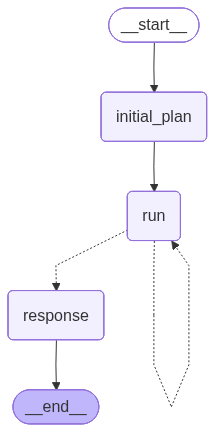

In [134]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
task = "Write a strategic one-pager of building an AI startup"

# FIXME: 生成计划后，无法正确执行，反复报 'Sorry, need more steps to process this request.'。
result = await graph.ainvoke({"task": task})

task: Write a strategic one-pager of building an AI startup
plan: steps=['Define the core mission and vision of the AI startup, specifying the problem it solves and the target market.', 'Identify the unique value proposition (UVP) that differentiates the startup from competitors, focusing on proprietary technology, data advantage, or operational efficiency.', 'Outline the key AI technologies and methodologies the startup will leverage (e.g., generative AI, computer vision, NLP, reinforcement learning) with specific use cases.', 'Map the target customer segments and describe how the product/service addresses their pain points with measurable outcomes.', 'Detail the go-to-market strategy including sales channels, pricing model, and early adopter acquisition plan.', 'Describe the founding team’s relevant expertise in AI, engineering, and business, highlighting key hires or partnerships needed.', 'Present a high-level financial roadmap: initial funding requirements, revenue projections for

CancelledError: 